In [1]:
from copy import copy

%matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sgeom
from osgeo import gdal, ogr
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import numpy.ma as ma
from pandas.tseries import offsets
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import img_tiles
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import subprocess as sp
from matplotlib.transforms import offset_copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib
%matplotlib inline

In [2]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [3]:
def scale_bar(ax, length, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    #Projection in metres, need to change this to suit your own figure
    utm = img_tiles.GoogleTiles().crs#ccrs.UTM(36)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    #Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
            horizontalalignment='center', verticalalignment='bottom', size=13)

In [4]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    img_extent = (extent[0], extent[1], extent[2], extent[3])
    
    # create a grid of xy coordinates in the original projection
    #xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, img_extent#, xy_source, proj

In [5]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks, label=True):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    if label == True:        
        ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    if label == False:
        ax.set_xticklabels([])
    

def lambert_yticks(ax, ticks, label=True):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    if label == True:
        ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])
    if label == False:
        ax.set_yticklabels([])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [6]:
# Create a Lambert Conformal projection:
proj = ccrs.LambertConformal(central_longitude=117.175, central_latitude=33.65,
                             false_easting=400000, false_northing=400000,
                             standard_parallels=(33, 34))

extent = [116.84693268,117.42693268,33.27324112,34.10324112]
xticks = [116.75,117,117.25,117.5]
yticks = [33.1,33.4,33.7,34,34.4]

# prulletaria
ogr2ogr = r'C:\Program Files\GDAL//ogr2ogr.exe'
base_geom = r'D:\Data\ChinaShapefile\CHN_adm'
# county
in_file_county = base_geom + '//CHN_adm3.shp'    
outfile_county = 'county.shp'

command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_county, in_file_county,'-clipsrc',
           str(extent[0]-0.5),str(extent[3]+0.5),str(extent[1]+0.5),str(extent[2]-0.5),
           '-overwrite']
print (sp.list2cmdline(command))
norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
norm.communicate()
# first color is now gray, orignal brown was  #939393
cb_NDVI = make_colormap([c('#939393'), c('#6E423C'),0.11, c('#6E423C'), c('#87523B'),0.125, 
                         c('#87523B'), c('#A36C34'),0.25, c('#A36C34'), c('#BF9123'),0.375, 
                         c('#BF9123'), c('#DBC712'),0.5,  c('#DBC712'), c('#B3D604'),0.625, 
                         c('#B3D604'), c('#51B004'),0.75, c('#51B004'), c('#0A8701'),0.875, 
                         c('#0A8701'), c('#01611F'),1, c('#01611F')])

"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" county.shp D:\Data\ChinaShapefile\CHN_adm//CHN_adm3.shp -clipsrc 116.34693268 34.60324112 117.92693268 32.77324112 -overwrite


In [7]:
# get array informaiton
mcd12q1 = r'D:\Data\NDAI_VHI_GROUNDTRUTH//mcd12q1_h27v05_v3.tif'
extent_mcd12q1, img_extent_mcd12q1 = setMap(mcd12q1)

ds_mcd12q1 = gdal.Open(mcd12q1)
array_mcd12q1 = ds_mcd12q1.ReadAsArray()
array_mcd12q1 = ma.masked_equal(array_mcd12q1,12)
array_mcd12q1 = np.flipud(array_mcd12q1)

In [34]:
# row 1
sp01 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2001_289.tif'
sp02 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2001_321.tif'
sp03 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2001_353.tif'
sp04 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2002_017.tif'
sp05 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2002_049.tif'
sp06 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2002_081.tif'
sp07 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2002_113.tif'
sp08 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2002_145.tif'
# row 2
sp09 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2007_289.tif'
sp10 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2007_321.tif'
sp11 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2007_353.tif'
sp12 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2008_017.tif'
sp13 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2008_049.tif'
sp14 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2008_081.tif'
sp15 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2008_113.tif'
sp16 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2008_145.tif'
# row 3
sp17 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2010_289.tif'
sp18 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2010_321.tif'
sp19 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2010_353.tif'
sp20 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_017.tif'
sp21 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_049.tif'
sp22 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_081.tif'
sp23 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_113.tif'
sp24 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_145.tif'
# row 4
sp25 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_289.tif'
sp26 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_321.tif'
sp27 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2011_353.tif'
sp28 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2012_017.tif'
sp29 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2012_049.tif'
sp30 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2012_081.tif'
sp31 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2012_113.tif'
sp32 = r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_month10_06//MOD13A2_2012_145.tif'

extent_ndvi, img_extent_ndvi = setMap(sp01)

ds_sp01 = gdal.Open(sp01)
array_sp01 = ds_sp01.ReadAsArray()
array_sp01 = np.flipud(array_sp01)
array_sp01 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp01)

ds_sp02 = gdal.Open(sp02)
array_sp02 = ds_sp02.ReadAsArray()
array_sp02 = np.flipud(array_sp02)
array_sp02 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp02)

ds_sp03 = gdal.Open(sp03)
array_sp03 = ds_sp03.ReadAsArray()
array_sp03 = np.flipud(array_sp03)
array_sp03 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp03)

ds_sp04 = gdal.Open(sp04)
array_sp04 = ds_sp04.ReadAsArray()
array_sp04 = np.flipud(array_sp04)
array_sp04 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp04)

ds_sp05 = gdal.Open(sp05)
array_sp05 = ds_sp05.ReadAsArray()
array_sp05 = np.flipud(array_sp05)
array_sp05 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp05)

ds_sp06 = gdal.Open(sp06)
array_sp06 = ds_sp06.ReadAsArray()
array_sp06 = np.flipud(array_sp06)
array_sp06 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp06)

ds_sp07 = gdal.Open(sp07)
array_sp07 = ds_sp07.ReadAsArray()
array_sp07 = np.flipud(array_sp07)
array_sp07 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp07)

ds_sp08 = gdal.Open(sp08)
array_sp08 = ds_sp08.ReadAsArray()
array_sp08 = np.flipud(array_sp08)
array_sp08 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp08)

ds_sp09 = gdal.Open(sp09)
array_sp09 = ds_sp09.ReadAsArray()
array_sp09 = np.flipud(array_sp09)
array_sp09 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp09)

ds_sp10 = gdal.Open(sp10)
array_sp10 = ds_sp10.ReadAsArray()
array_sp10 = np.flipud(array_sp10)
array_sp10 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp10)

ds_sp11 = gdal.Open(sp11)
array_sp11 = ds_sp11.ReadAsArray()
array_sp11 = np.flipud(array_sp11)
array_sp11 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp11)

ds_sp12 = gdal.Open(sp12)
array_sp12 = ds_sp12.ReadAsArray()
array_sp12 = np.flipud(array_sp12)
array_sp12 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp12)

ds_sp13 = gdal.Open(sp13)
array_sp13 = ds_sp13.ReadAsArray()
array_sp13 = np.flipud(array_sp13)
array_sp13 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp13)

ds_sp14 = gdal.Open(sp14)
array_sp14 = ds_sp14.ReadAsArray()
array_sp14 = np.flipud(array_sp14)
array_sp14 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp14)

ds_sp15 = gdal.Open(sp15)
array_sp15 = ds_sp15.ReadAsArray()
array_sp15 = np.flipud(array_sp15)
array_sp15 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp15)

ds_sp16 = gdal.Open(sp16)
array_sp16 = ds_sp16.ReadAsArray()
array_sp16 = np.flipud(array_sp16)
array_sp16 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp16)

ds_sp17 = gdal.Open(sp17)
array_sp17 = ds_sp17.ReadAsArray()
array_sp17 = np.flipud(array_sp17)
array_sp17 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp17)

ds_sp18 = gdal.Open(sp18)
array_sp18 = ds_sp18.ReadAsArray()
array_sp18 = np.flipud(array_sp18)
array_sp18 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp18)

ds_sp19 = gdal.Open(sp19)
array_sp19 = ds_sp19.ReadAsArray()
array_sp19 = np.flipud(array_sp19)
array_sp19 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp19)

ds_sp20 = gdal.Open(sp20)
array_sp20 = ds_sp20.ReadAsArray()
array_sp20 = np.flipud(array_sp20)
array_sp20 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp20)

ds_sp21 = gdal.Open(sp21)
array_sp21 = ds_sp21.ReadAsArray()
array_sp21 = np.flipud(array_sp21)
array_sp21 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp21)

ds_sp22 = gdal.Open(sp22)
array_sp22 = ds_sp22.ReadAsArray()
array_sp22 = np.flipud(array_sp22)
array_sp22 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp22)

ds_sp23 = gdal.Open(sp23)
array_sp23 = ds_sp23.ReadAsArray()
array_sp23 = np.flipud(array_sp23)
array_sp23 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp23)

ds_sp24 = gdal.Open(sp24)
array_sp24 = ds_sp24.ReadAsArray()
array_sp24 = np.flipud(array_sp24)
array_sp24 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp24)

ds_sp25 = gdal.Open(sp25)
array_sp25 = ds_sp25.ReadAsArray()
array_sp25 = np.flipud(array_sp25)
array_sp25 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp25)

ds_sp26 = gdal.Open(sp26)
array_sp26 = ds_sp26.ReadAsArray()
array_sp26 = np.flipud(array_sp26)
array_sp26 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp26)

ds_sp27 = gdal.Open(sp27)
array_sp27 = ds_sp27.ReadAsArray()
array_sp27 = np.flipud(array_sp27)
array_sp27 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp27)

ds_sp28 = gdal.Open(sp28)
array_sp28 = ds_sp28.ReadAsArray()
array_sp28 = np.flipud(array_sp28)
array_sp28 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp28)

ds_sp29 = gdal.Open(sp29)
array_sp29 = ds_sp29.ReadAsArray()
array_sp29 = np.flipud(array_sp29)
array_sp29 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp29)

ds_sp30 = gdal.Open(sp30)
array_sp30 = ds_sp30.ReadAsArray()
array_sp30 = np.flipud(array_sp30)
array_sp30 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp30)

ds_sp31 = gdal.Open(sp31)
array_sp31 = ds_sp31.ReadAsArray()
array_sp31 = np.flipud(array_sp31)
array_sp31 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp31)

ds_sp32 = gdal.Open(sp32)
array_sp32 = ds_sp32.ReadAsArray()
array_sp32 = np.flipud(array_sp32)
array_sp32 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), array_sp32)

In [35]:
year = int(sp01[-12:-8])
doy  = int(sp01[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp01 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp02[-12:-8])
doy  = int(sp02[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp02 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp03[-12:-8])
doy  = int(sp03[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp03 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp04[-12:-8])
doy  = int(sp04[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp04 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp05[-12:-8])
doy  = int(sp05[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp05 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp06[-12:-8])
doy  = int(sp06[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp06 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp07[-12:-8])
doy  = int(sp07[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp07 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp08[-12:-8])
doy  = int(sp08[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp08 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp09[-12:-8])
doy  = int(sp09[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp09 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp10[-12:-8])
doy  = int(sp10[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp10 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp11[-12:-8])
doy  = int(sp11[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp11 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp12[-12:-8])
doy  = int(sp12[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp12 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp13[-12:-8])
doy  = int(sp13[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp13 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp14[-12:-8])
doy  = int(sp14[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp14 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp15[-12:-8])
doy  = int(sp15[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp15 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp16[-12:-8])
doy  = int(sp16[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp16 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp17[-12:-8])
doy  = int(sp17[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp17 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp18[-12:-8])
doy  = int(sp18[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp18 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp19[-12:-8])
doy  = int(sp19[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp19 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp20[-12:-8])
doy  = int(sp20[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp20 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp21[-12:-8])
doy  = int(sp21[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp21 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp22[-12:-8])
doy  = int(sp22[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp22 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp23[-12:-8])
doy  = int(sp23[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp23 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp24[-12:-8])
doy  = int(sp24[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp24 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp25[-12:-8])
doy  = int(sp25[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp25 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp26[-12:-8])
doy  = int(sp26[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp26 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp27[-12:-8])
doy  = int(sp27[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp27 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp28[-12:-8])
doy  = int(sp28[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp28 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp29[-12:-8])
doy  = int(sp29[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp29 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp30[-12:-8])
doy  = int(sp30[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp30 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp31[-12:-8])
doy  = int(sp31[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp31 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

year = int(sp32[-12:-8])
doy  = int(sp32[-7:-4])
date = datetime(year, 1, 1) + timedelta(doy - 1)
date_sp32 = str(date.year)+'-'+str(date.month).zfill(2)+'-'+str(date.day).zfill(2)

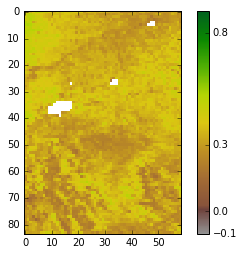

In [11]:
bounds = [-0.1,0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
cmap = cmap_discretize(cb_NDVI,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(array_0405/10000., cmap=cb_NDVI, vmin=-0.1, vmax=0.9,
               interpolation='nearest')#, norm=norm)
plt.colorbar(im, ticks=[-0.1,0,0.3,0.8])

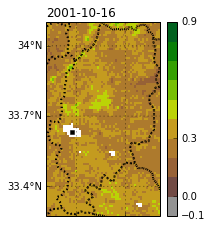

In [36]:
# Draw a set of axes with coastlines:
fig = plt.figure(figsize=(24, 16), frameon=True)

# PLOT 1
ax = plt.subplot(4,8,1, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp01/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
plt.colorbar(im, ticks=[-0.1,0,0.3,0.9], ax=ax)
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp01,loc='left')

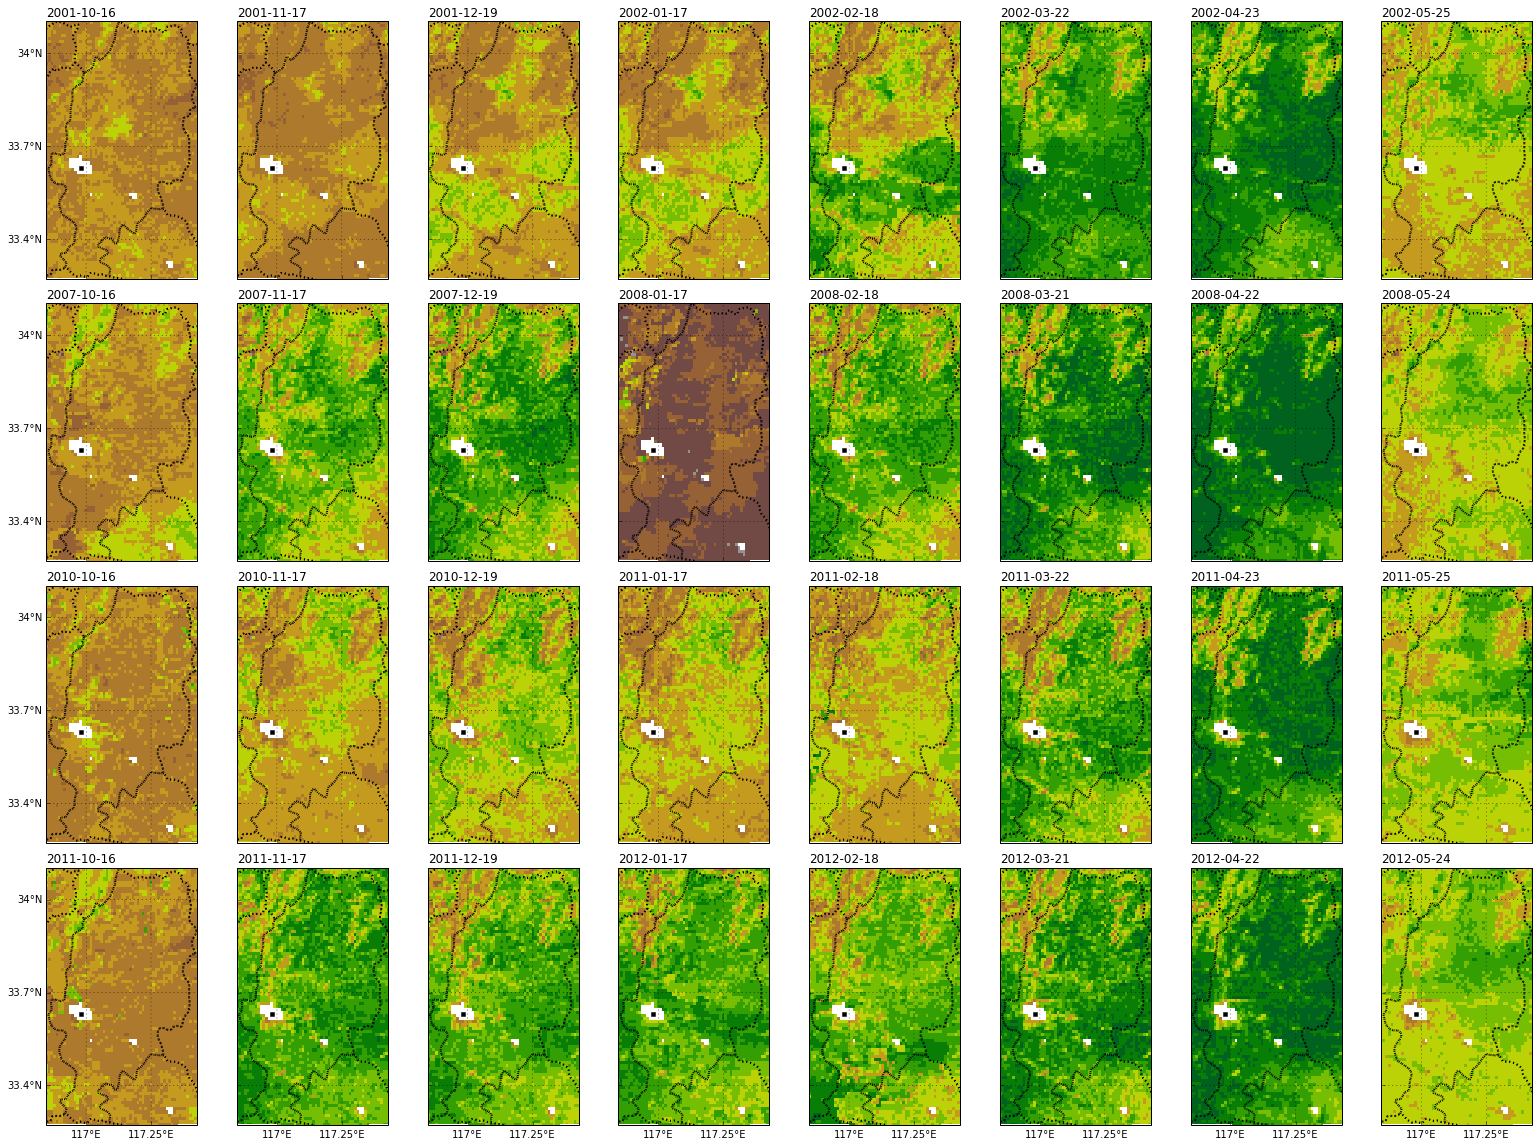

In [40]:
# Draw a set of axes with coastlines:
fig = plt.figure(figsize=(22, 16), frameon=True)

# ROW  1
# PLOT 1
ax = plt.subplot(4,8,1, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp01/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp01,loc='left')

# PLOT 2
ax = plt.subplot(4,8,2, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp02/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp02,loc='left')

# PLOT 3
ax = plt.subplot(4,8,3, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp03/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp03,loc='left')

# PLOT 4
ax = plt.subplot(4,8,4, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp04/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp04,loc='left')

# PLOT 5
ax = plt.subplot(4,8,5, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp05/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp05,loc='left')

# PLOT 6
ax = plt.subplot(4,8,6, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp06/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp06,loc='left')

# PLOT 7
ax = plt.subplot(4,8,7, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp07/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp07,loc='left')

# PLOT 8
ax = plt.subplot(4,8,8, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp08/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp08,loc='left')

# ---------------------------------------------------------------------------------------
# ROW  2
# PLOT 9
ax = plt.subplot(4,8,9, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp09/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp09,loc='left')

# PLOT 10
ax = plt.subplot(4,8,10, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp10/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp10,loc='left')

# PLOT 11
ax = plt.subplot(4,8,11, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp11/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp11,loc='left')

# PLOT 12
ax = plt.subplot(4,8,12, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp12/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp12,loc='left')

# PLOT 13
ax = plt.subplot(4,8,13, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp13/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp13,loc='left')

# PLOT 14
ax = plt.subplot(4,8,14, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp14/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp14,loc='left')

# PLOT 15
ax = plt.subplot(4,8,15, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp15/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp15,loc='left')

# PLOT 16
ax = plt.subplot(4,8,16, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp16/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp16,loc='left')

# ---------------------------------------------------------------------------------------
# ROW  3
# PLOT 17
ax = plt.subplot(4,8,17, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp17/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp17,loc='left')

# PLOT 18
ax = plt.subplot(4,8,18, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp18/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp18,loc='left')

# PLOT 19
ax = plt.subplot(4,8,19, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp19/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp19,loc='left')

# PLOT 20
ax = plt.subplot(4,8,20, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp20/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp20,loc='left')

# PLOT 21
ax = plt.subplot(4,8,21, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp21/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp21,loc='left')

# PLOT 22
ax = plt.subplot(4,8,22, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp22/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp22,loc='left')

# PLOT 23
ax = plt.subplot(4,8,23, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp23/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp23,loc='left')

# PLOT 24
ax = plt.subplot(4,8,24, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp24/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp24,loc='left')

# ---------------------------------------------------------------------------------------
# ROW  4
# PLOT 25
ax = plt.subplot(4,8,25, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp25/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp25,loc='left')

# PLOT 26
ax = plt.subplot(4,8,26, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp26/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp26,loc='left')

# PLOT 27
ax = plt.subplot(4,8,27, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp27/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp27,loc='left')

# PLOT 28
ax = plt.subplot(4,8,28, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp28/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp28,loc='left')

# PLOT 29
ax = plt.subplot(4,8,29, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp29/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp29,loc='left')

# PLOT 30
ax = plt.subplot(4,8,30, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp30/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp30,loc='left')

# PLOT 31
ax = plt.subplot(4,8,31, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp31/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp31,loc='left')

# PLOT 32
ax = plt.subplot(4,8,32, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)#, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_sp32/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=4,
        transform=ccrs.PlateCarree())
ax.set_title(date_sp32,loc='left')

plt.tight_layout()
plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//Yongqiao_row1_4.png', 
            dpi=400, bbox_inches='tight')
plt.show()


In [ ]:


# PLOT 2
ax = plt.subplot(332, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0506/10000., origin='upper', extent=img_extent_ndvi, 
               cmap=cb_NDVI, vmin=-0.1, vmax=0.9, 
               interpolation='nearest', transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0506[-14:-4],loc='left')

# PLOT 3
ax = plt.subplot(333, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0607/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0607[-14:-4],loc='left')

# PLOT 4
ax = plt.subplot(334, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0708/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0708[-14:-4],loc='left')

# PLOT 5
ax = plt.subplot(335, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0809/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0809[-14:-4],loc='left')

# PLOT 6
ax = plt.subplot(336, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0910/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0910[-14:-4],loc='left')

# PLOT 7
ax = plt.subplot(337, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_1011/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_1011[-14:-4],loc='left')
scale_bar(ax, 10)

# PLOT 8
ax = plt.subplot(338, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_1112/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_1112[-14:-4],loc='left')

# PLOT 9
ax = plt.subplot(339, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_1213/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_1213[-14:-4],loc='left')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.00, 0.35, 0.04, 0.298])
fig.colorbar(im, cax=cbar_ax, ticks=[-0.1,0,0.3,0.9])

plt.tight_layout()
plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//Yongqiao_'+ndvi_1213[-9:-4]+'.png', 
            dpi=400, bbox_inches='tight')

In [ ]:
im = plt.imshow(array_1213/10000.)
plt.colorbar(im)